# Aggregate hourly gridded data to daily/monthly/annual means


| Var               | daily | monthly | annual |
|-------------------|-------|---------|--------|
| CAMS PM10         |   x   |    x    |   x    | 
| CAMS PM2.5        |   x   |    x    |   x    | 
| CAMS O3           |   x   |    x    |   x    | 
| CAMS NO2          |   x   |    x    |   x    |  
| Wind speed        |   x   |    x    |   x    |
| Wind direction    |   x   |    x    |   x    |  
| Relative humidity |   x   |    x    |   x    |  
| Temperature       |   x   |    x    |   x    |  
| Solar radiation   |   x   |    x    |   x    |  


In [19]:
import gc
import glob
import os.path

import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.distributed import Client, LocalCluster, progress
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir("/mnt/cloud/wwu1/ec_bronze/_nogroup/ae78a1ca-a0e8-4e4e-8992-69c34947db65/UseCase_AIRCON")

In [20]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36575,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 3 hours ago,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:43873,Total threads: 4
Dashboard: http://127.0.0.1:37601/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43811,


In [21]:
variables = ['pm10','pm2p5','no2','o3','wind_speed','wind_direction','rel_humidity','temperature','solar_radiation']
years = range(2015, 2024)

Specify variable and temporal resolution

- t = "D" for daily
- t = "M" for monthly
- t = "Y" for annual

From VRA2020 and IRA2022, the grid definition is:

700 x 420 gridpoints:
- from -24.95°E to 44.95°E
- from 30.05°N to 71.95°N 
- Resolution 0.1° x 0.1°

For all previous productions (to VRA2020 and IRA2022) the grid definition is :

701 x 421 gridpoints:
- from -25°E to 45°E
- from 30.0°N to 72°N 
- Resolution 0.1° x 0.1°

## Daily Aggregates

In [22]:
def right_dir(var):
    
    cams = ['pm10','pm2p5','no2','o3']
    era5 = ['wind_speed','wind_direction','rel_humidity','temperature','solar_radiation']
    dir = 0
    
    if var in cams:
        dir = 'cams_download'
        return dir
    if var in era5:
        dir = 'era5_download'
        return dir
    if dir == 0:
        print(f"No directory found for variable {var}.")

def temp_aggregate_daily(var, y):
    
    out = f"supplementary/01_daily/{var}_daily_{y}.nc"
    if not os.path.isfile(out) or os.path.getsize(out) < 50000:

        dr = right_dir(var)
        files = glob.glob(f"supplementary/{dr}/*{var}*{y}*")
        files.sort()

        chunkies = "auto"
        if len(files) > 1:
            if y > 2022 and dr == 'cams_download':
                var_h = xr.open_mfdataset(files, chunks = chunkies, concat_dim = "time", combine = "nested") 
                var_h.coords['time'] = pd.date_range(start=f"{y}-01-01 00:00:00", end = f"{y}-12-31 23:00:00", freq='H')
                var_h = var_h.rename_vars({list(var_h.keys())[0]: v})
                print(f"\nFound deltatimeIndex for {var} data from {y}. Reindexing with hourly datetime.")
            else:
                var_h = xr.open_mfdataset(files, chunks = chunkies)            
        if len(files) == 1:
            var_h = xr.open_dataset(files[0], chunks = chunkies)
            
        if 'expver' in var_h.dims:
            var_h = var_h.reduce(np.nansum, 'expver')
            print(f"\nFound experimental version of {var} data from {y}. Reducing dimensions.")
        if 'level' in var_h.coords:
            var_h = var_h.reduce(np.nansum, 'level')
            print(f"\nFound level variable in {var} data from {y}. Reducing dimensions.")
            
        agg = var_h.resample(time="D").mean(skipna=True).to_netcdf(out, mode="w", compute=False)

        del var_h    
        #gc.collect()
        return agg
        del agg

In [23]:
%%time

lazy_results = []

for v in variables:
    print("\n"+v)
    for y in years:
        agg_d = temp_aggregate_daily(v, y)
        lazy_results.append(agg_d)
        print(y, sep=' ', end=' ', flush=True)


pm10
2015 2016 2017 2018 2019 2020 2021 2022 2023 
pm2p5
2015 2016 2017 2018 2019 2020 2021 2022 2023 
no2
2015 2016 2017 2018 2019 2020 2021 2022 2023 
o3
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_speed
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_direction
2015 2016 2017 2018 2019 2020 2021 2022 2023 
rel_humidity
2015 2016 2017 2018 2019 2020 2021 2022 2023 
temperature
2015 2016 2017 2018 2019 2020 2021 2022 2023 
solar_radiation
2015 2016 2017 2018 2019 2020 2021 2022 2023 CPU times: user 1.28 s, sys: 346 ms, total: 1.62 s
Wall time: 3.6 s


In [25]:
len(lazy_results)

81

In [26]:
lazy_results = [x for x in lazy_results if x is not None]
len(lazy_results)

9

In [27]:
agg_res = dask.persist(*lazy_results)
progress(agg_res)

VBox()

## Monthly aggregates

Use previously processed daily means and aggregate to monthly.

In [28]:
def temp_aggregate_monthly(var, y):
    
    out = f"supplementary/02_monthly/{var}_monthly_{y}.nc"
    if not os.path.isfile(out):

        var_d = xr.open_mfdataset(f"supplementary/01_daily/{var}_daily_{y}.nc", chunks = 'auto') 
        agg = var_d.resample(time="M").mean(skipna=True).to_netcdf(out, mode="w", compute=False)
        
        return agg

In [29]:
%%time

lazy_results = []

for v in variables:
    print("\n"+v)
    for y in years:
        agg_m = temp_aggregate_monthly(v, y)
        lazy_results.append(agg_m)
        print(y, sep=' ', end=' ', flush=True)


pm10
2015 2016 2017 2018 2019 2020 2021 2022 2023 
pm2p5
2015 2016 2017 2018 2019 2020 2021 2022 2023 
no2
2015 2016 2017 2018 2019 2020 2021 2022 2023 
o3
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_speed
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_direction
2015 2016 2017 2018 2019 2020 2021 2022 2023 
rel_humidity
2015 2016 2017 2018 2019 2020 2021 2022 2023 
temperature
2015 2016 2017 2018 2019 2020 2021 2022 2023 
solar_radiation
2015 2016 2017 2018 2019 2020 2021 2022 2023 CPU times: user 889 ms, sys: 330 ms, total: 1.22 s
Wall time: 2.65 s


In [30]:
lazy_results = [x for x in lazy_results if x is not None]
len(lazy_results)

9

In [31]:
agg_res = dask.persist(*lazy_results)
progress(agg_res)

VBox()

## Annual aggregates

Use previously processed monthly means and aggregate to annual.

In [32]:
def temp_aggregate_annual(var, y):
    
    out = f"supplementary/03_annual/{var}_annual_{y}.nc"
    if not os.path.isfile(out) or os.path.getsize(out) < 50000:

        var_a = xr.open_dataset(f"supplementary/02_monthly/{var}_monthly_{y}.nc", chunks = 'auto')
        agg = var_a.resample(time="A").mean(skipna=True).to_netcdf(out, mode="w", compute=False)
        return agg

In [33]:
%%time

lazy_results = []

for v in variables:
    print("\n"+v)
    for y in years:
        agg_a = temp_aggregate_annual(v, y)
        lazy_results.append(agg_a)
        print(y, sep=' ', end=' ', flush=True)


pm10
2015 2016 2017 2018 2019 2020 2021 2022 2023 
pm2p5
2015 2016 2017 2018 2019 2020 2021 2022 2023 
no2
2015 2016 2017 2018 2019 2020 2021 2022 2023 
o3
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_speed
2015 2016 2017 2018 2019 2020 2021 2022 2023 
wind_direction
2015 2016 2017 2018 2019 2020 2021 2022 2023 
rel_humidity
2015 2016 2017 2018 2019 2020 2021 2022 2023 
temperature
2015 2016 2017 2018 2019 2020 2021 2022 2023 
solar_radiation
2015 2016 2017 2018 2019 2020 2021 2022 2023 CPU times: user 603 ms, sys: 167 ms, total: 770 ms
Wall time: 832 ms


In [34]:
lazy_results = [x for x in lazy_results if x is not None]
len(lazy_results)

9

In [35]:
agg_res = dask.persist(*lazy_results)
progress(agg_res)

VBox()

## Check and plot results

In [314]:
no2_2018 = xr.open_dataset("supplementary/03_annual/no2_annual_2018.nc")
no2_2020 = xr.open_dataset("supplementary/03_annual/no2_annual_2020.nc")
no2_2018

<xarray.Dataset>
Dimensions:  (time: 1, lat: 421, lon: 701)
Coordinates:
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 71.6 71.7 71.8 71.9 72.0
  * time     (time) datetime64[ns] 2018-12-31
Data variables:
    no2      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

**Compare annual NO2 pre- and during-COVID**

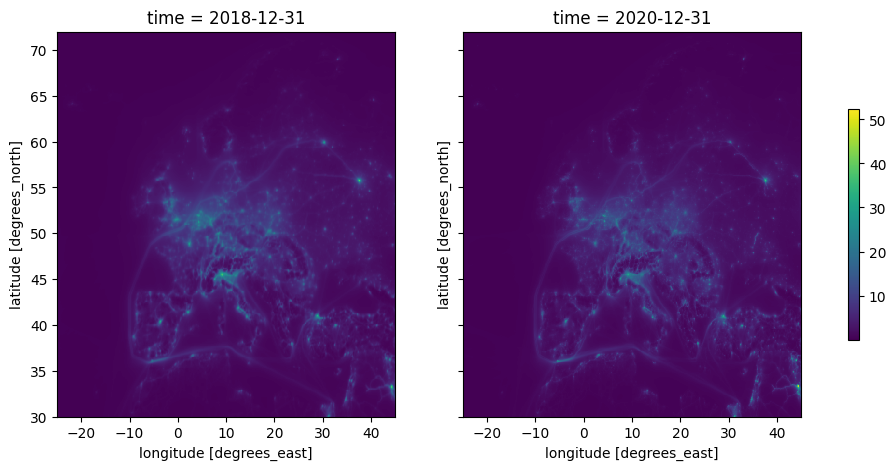

In [315]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

vmin = min(no2_2018.no2.min(), no2_2020.no2.min())
vmax = max(no2_2018.no2.max(), no2_2020.no2.max())

no2_2018.no2.plot(ax=axs[0], cmap='viridis', vmin=vmin, vmax=vmax, add_colorbar=False)
no2_2020.no2.plot(ax=axs[1], cmap='viridis', vmin=vmin, vmax=vmax, add_colorbar=False)

fig.colorbar(axs[1].collections[0], ax=axs, shrink=0.6)

plt.show()

In [77]:
fig.figure.savefig('../tests/NO2_2018_vs_2020_mean.png', format='png', dpi=300)